In [ ]:
# revise time-variable hydropotential surface of CS2 when you have served product with absolute heights

In [2]:
# Code to plot the local hydropotential field at known subglacial lakes for interpreting time-evolving lake shorelines
#
# Written 2022-08-28 by W. Sauthoff (sauthoff@mines.edu)

# import packages
import os
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'
import xarray
import rioxarray
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import richdem as rd
from matplotlib.colors import LogNorm
import datetime
from skimage import measure

# define data and script directory (replace with your data directory file path) and file path
data_dir = '/home/jovyan/data_dir'
script_dir = '/home/jovyan/script_dir'

def datetime2fracyear(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [3]:
# BedMachine Antarctica bed and surface topography v2
# https://nsidc.org/data/NSIDC-0756 
# more info: https://sites.uci.edu/morlighem/bedmachine-antarctica/
# relocate download to data_dir

# open Bedmachine netcdf dataset using xarray
BedMachine_ds = xarray.open_dataset(data_dir + '/beds/BedMachine/BedMachineAntarctica_2020-07-15_v02.nc')
# display file metadata
BedMachine_ds

<xarray.Dataset>
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
Data variables:
    mapping    |S1 ...
    mask       (y, x) int8 ...
    firn       (y, x) float32 ...
    surface    (y, x) float32 ...
    thickness  (y, x) float32 ...
    bed        (y, x) float32 ...
    errbed     (y, x) float32 ...
    source     (y, x) int8 ...
    geoid      (y, x) int16 ...
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     15-Jul-2020 (v2.0)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [4]:
# download Bedmap2 files from: 
# https://www.bas.ac.uk/project/bedmap-2/#data
# relocate download to data_dir

# open bed and surface into an xarray.DataArrays
Bedmap2_bed_da = rioxarray.open_rasterio(data_dir + '/beds/Bedmap2/bedmap2_tiff/bedmap2_bed.tif')
Bedmap2_surface_da = rioxarray.open_rasterio(data_dir + '/beds/Bedmap2/bedmap2_tiff/bedmap2_surface.tif')

# drop band and spatial_ref coordinates
Bedmap2_bed_da = Bedmap2_bed_da.drop_vars('band')
Bedmap2_bed_da = Bedmap2_bed_da.drop_vars('spatial_ref')
Bedmap2_surface_da = Bedmap2_surface_da.drop_vars('band')
Bedmap2_surface_da = Bedmap2_surface_da.drop_vars('spatial_ref')

# covert xarray.DataArray into a xarray.Dataset
Bedmap2_ds = Bedmap2_bed_da.to_dataset(name='bed')

# add surface xarray.DataArray as new data variable to xarray.Dataset
Bedmap2_ds['surface'] = Bedmap2_surface_da

# drop band dimension from data variables
Bedmap2_ds['bed'] = Bedmap2_ds['bed'].sel(band=0)
Bedmap2_ds['surface'] = Bedmap2_ds['surface'].sel(band=0)

# add Title attribute
Bedmap2_ds.attrs['Title'] = 'Bedmap2'

# display metadata of xarray.Dataset
Bedmap2_ds

<xarray.Dataset>
Dimensions:  (x: 6667, y: 6667)
Coordinates:
  * x        (x) float64 -3.333e+06 -3.332e+06 ... 3.332e+06 3.333e+06
  * y        (y) float64 3.333e+06 3.332e+06 3.331e+06 ... -3.332e+06 -3.333e+06
Data variables:
    bed      (y, x) int16 ...
    surface  (y, x) int16 ...
Attributes:
    Title:    Bedmap2

In [5]:
# import CryoSat-2 data (closed-source data acquired from Ben Smith)
CS2_data = open(script_dir + '/Smith_CS2.py')
read_file = CS2_data.read()
exec(read_file)

# add Title attribute
CS2_dh.attrs['Title'] = 'CS2'

# view data set
CS2_dh

OSError: Unable to open file (truncated file: eof = 9867100160, sblock->base_addr = 0, stored_eof = 52795082968)

In [6]:
# import ICESat-2 ATL14 Gridded Antarctic Land Ice Height Change data product (static digital elev. model)
# https://doi.org/10.5067/ATLAS/ATL14.002
# relocate to data_dir

file = data_dir + '/altimetry/ICESat-2/ATL14.002-Ant/ATL14_AA_0314_100m_002_02.nc'
ATL14_dh = rioxarray.open_rasterio(file, masked=True)
# just look at essential data
ATL14_dh = ATL14_dh[0]
# transpose order of dimensions to be similar to ATL15_dh
ATL14_dh.transpose('y','x','band')
# drop band dimension
ATL14_dh.drop_dims('band') # DOESN'T SEEM TO WORK
ATL14_dh

# granule = 's3://is2view/ATLAS/ATL14/002/2019/ATL14_AA_0314_100m_002_02.nc'
# ATL14_dh = rioxarray.open_rasterio(granule, masked=True)

# display xarray data set meta data
ATL14_dh

RasterioIOError: /home/jovyan/data_dir/altimetry/ICESat-2/ATL14.002-Ant/ATL14_AA_0314_100m_002_02.nc: No such file or directory

In [7]:
# import ICESat-2 ATL15 Gridded Antarctic and Arctic Land Ice Height Change data product 
# https://doi.org/10.5067/ATLAS/ATL15.001
# relocate to data_dir

# file = data_dir + '/altimetry/ICESat-2/ATL15.001-Ant/ATL15_AA_0311_01km_001_01.nc'
# ATL15_dh = rioxarray.open_rasterio(file, group='delta_h', masked=True)

granule = 's3://is2view/ATLAS/ATL15/002/2019/ATL15_AA_0314_01km_002_02.nc'
group = 'delta_h'
ATL15_dh = rioxarray.open_rasterio(granule, group=group, masked=True)

# display xarray data set meta data
ATL15_dh

<xarray.Dataset>
Dimensions:              (time: 15, x: 5461, y: 4461)
Coordinates:
  * time                 (time) float64 273.9 365.2 ... 1.461e+03 1.552e+03
  * x                    (x) float64 -2.67e+06 -2.669e+06 ... 2.789e+06 2.79e+06
  * y                    (y) float64 2.27e+06 2.269e+06 ... -2.189e+06 -2.19e+06
    Polar_Stereographic  int64 0
Data variables:
    ice_area             (time, y, x) float32 ...
    delta_h              (time, y, x) float32 ...
    delta_h_sigma        (time, y, x) float32 ...
    data_count           (time, y, x) float32 ...
    misfit_rms           (time, y, x) float32 ...
    misfit_scaled_rms    (time, y, x) float32 ...
Attributes: (12/117)
    description:                        This data set (ATL15) contains season...
    identifier:                         atl15_qa_util
    pulse_rate:                         10000 pps
    type:                               Spacecraft
    wavelength:                         532 nm
    Description:                        Describe the group
    ...                                 ...
    summary:                            The purpose of ATL15 is to provide an...
    time_coverage_duration:             94150869.62631059
    time_coverage_end:                  2022-03-23T03:19:26.843657Z
    time_coverage_start:                2019-03-29T10:18:17.217346Z
    time_type:                          CCSDS UTC-A
    vertical_datum:                     WGS84

In [8]:
# assign new data variable of absolute heights (ATL14 DEM + ATL15 dh) to ATL15_dh xarray.Dataset
ATL15_dh = ATL15_dh.assign(h = ATL15_dh['delta_h'] + ATL14_dh['h'][0,:,:])

# add Title attribute
ATL15_dh.attrs['Title'] = 'IS2'

ATL15_dh

NameError: name 'ATL14_dh' is not defined

In [ ]:
# assign again but using Bedmap2 surface/bed topography instead
Bedmap2_ds = Bedmap2_ds.assign(hydropotential_kPa_static = (9.81 * ((997-917)*Bedmap2_ds['bed'] + 917*Bedmap2_ds['surface']))*(1/1e3))

Bedmap2_ds

In [ ]:
(9.81 * (((997-917)*32767) + (917*32767)))*(1/1e3)

In [7]:
(9.81 * (((997-917)*Bedmap2_ds['bed'][0,0]) + (917*Bedmap2_ds['surface'][0,0])))*(1/1e3)

<xarray.DataArray ()>
array(320479.93719)
Coordinates:
    x        float64 -3.333e+06
    y        float64 3.333e+06

In [8]:
Bedmap2_ds['surface'][0,0]

<xarray.DataArray 'surface' ()>
array(32767, dtype=int16)
Coordinates:
    x        float64 -3.333e+06
    y        float64 3.333e+06
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     32767
    scale_factor:   1.0
    add_offset:     0.0

In [11]:
# assign new data variable of hydropotential to ATL15_dh xarray.Dataset
# follows Shreve 1972
# adds g (gravitational acceleration) to make units Pa and unit conversion to kPa
# use BedMachine Antarctica bed topography for Zbed and static BedMachine Antarctica surface topography for Zsurf
BedMachine_ds = BedMachine_ds.assign(hydropotential_kPa_static = (9.81 * ((997-917)*BedMachine_ds['bed'] + 917*BedMachine_ds['surface']))*(1/1e3))

BedMachine_ds

<xarray.Dataset>
Dimensions:                    (x: 13333, y: 13333)
Coordinates:
  * x                          (x) int32 -3333000 -3332500 ... 3332500 3333000
  * y                          (y) int32 3333000 3332500 ... -3332500 -3333000
Data variables:
    mapping                    |S1 ...
    mask                       (y, x) int8 ...
    firn                       (y, x) float32 ...
    surface                    (y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    thickness                  (y, x) float32 ...
    bed                        (y, x) float32 -5.916e+03 ... -3.665e+03
    errbed                     (y, x) float32 ...
    source                     (y, x) int8 ...
    geoid                      (y, x) int16 ...
    hydropotential_kPa_static  (y, x) float32 -4.643e+03 ... -2.876e+03
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     15-Jul-2020 (v2.0)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

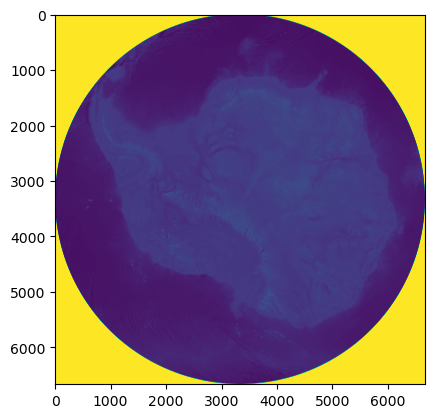

In [14]:
plt.imshow(Bedmap2_ds['bed'])

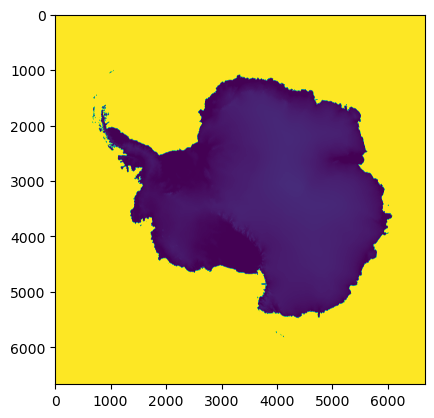

In [9]:
plt.imshow(Bedmap2_ds['surface'])

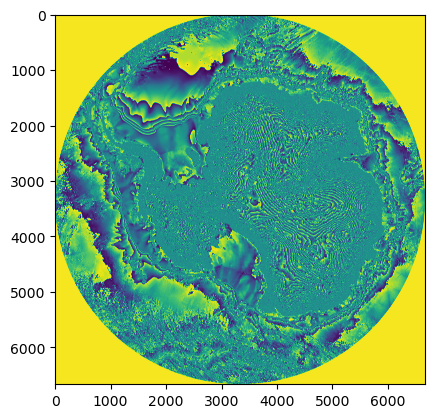

In [10]:
plt.imshow(Bedmap2_ds['hydropotential_kPa_static'])

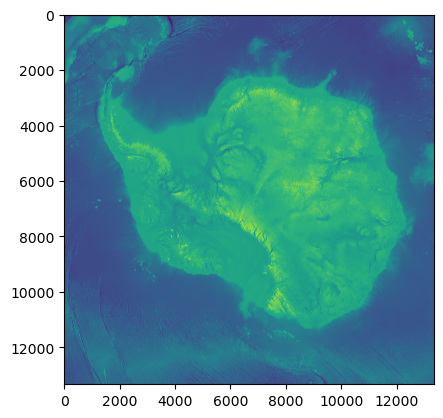

In [11]:
plt.imshow(BedMachine_ds['bed'])

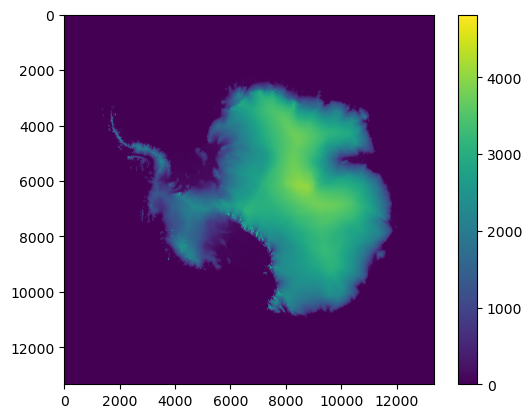

In [11]:
plt.imshow(BedMachine_ds['surface'])
plt.colorbar()

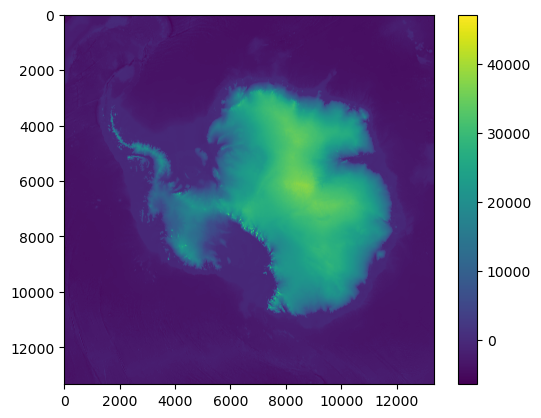

In [10]:
plt.imshow(BedMachine_ds['hydropotential_kPa_static'])
plt.colorbar()

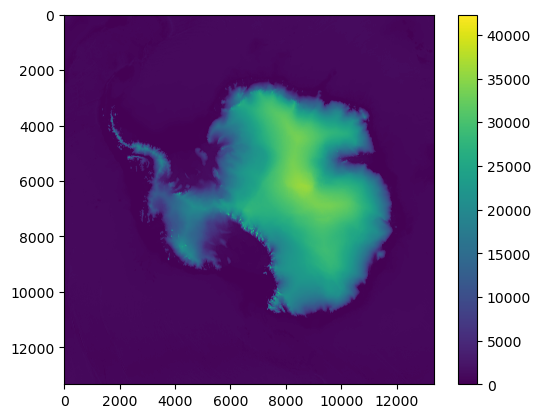

In [12]:
plt.imshow(BedMachine_ds['hydropotential_kPa_static']-BedMachine_ds['bed'])
plt.colorbar()

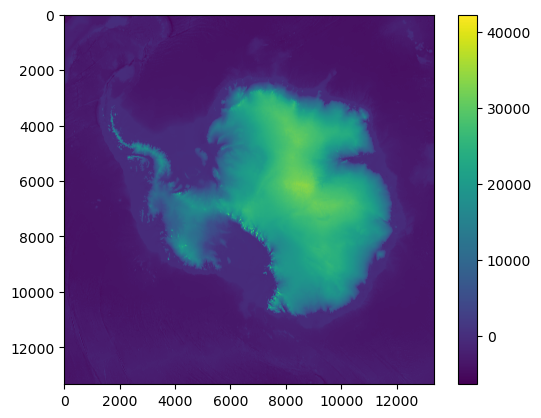

In [13]:
plt.imshow(BedMachine_ds['hydropotential_kPa_static']-BedMachine_ds['surface'])
plt.colorbar()

In [10]:
# repeat hydropotential calculation but use time variable dh for Zsurf
ATL15_dh = ATL15_dh.assign(hydropotential_kPa_BedMachine = (9.81 * ((997-917)*BedMachine_ds['bed'] + 917*ATL15_dh['h']))*(1/1e3))
ATL15_dh = ATL15_dh.assign(hydropotential_kPa_Bedmap2 = (9.81 * ((997-917)*Bedmap2_ds['bed'] + 917*ATL15_dh['h']))*(1/1e3))

ATL15_dh

<xarray.Dataset>
Dimensions:                        (y: 4461, x: 5461, time: 15)
Coordinates:
  * y                              (y) float64 2.27e+06 2.269e+06 ... -2.19e+06
  * x                              (x) float64 -2.67e+06 -2.669e+06 ... 2.79e+06
  * time                           (time) float64 273.9 365.2 ... 1.552e+03
    Polar_Stereographic            int64 0
    band                           int64 1
Data variables:
    ice_area                       (time, y, x) float32 ...
    delta_h                        (time, y, x) float32 ...
    delta_h_sigma                  (time, y, x) float32 ...
    data_count                     (time, y, x) float32 ...
    misfit_rms                     (time, y, x) float32 ...
    misfit_scaled_rms              (time, y, x) float32 ...
    h                              (time, y, x) float32 nan nan nan ... nan nan
    hydropotential_kPa_BedMachine  (y, x, time) float32 nan nan nan ... nan nan
    hydropotential_kPa_Bedmap2     (y, x, time) float32 nan nan nan ... nan nan
Attributes: (12/118)
    description:                        This data set (ATL15) contains season...
    identifier:                         atl15_qa_util
    pulse_rate:                         10000 pps
    type:                               Spacecraft
    wavelength:                         532 nm
    Description:                        Describe the group
    ...                                 ...
    time_coverage_duration:             94150869.62631059
    time_coverage_end:                  2022-03-23T03:19:26.843657Z
    time_coverage_start:                2019-03-29T10:18:17.217346Z
    time_type:                          CCSDS UTC-A
    vertical_datum:                     WGS84
    Title:                              IS2

In [11]:
# repeat time-variable hydropotential calculation on CryoSat-2 data (WAIT UNTIL YOU HAVE SERVED PRODUCT WITH ABS HEIGHTS)


In [23]:
# import subglacial lake outlines 
outlines = open(script_dir + '/Smith2009_outlines.py')
read_file = outlines.read()
exec(read_file)

outlines = open(script_dir + '/SiegfriedFricker2018_outlines.py')
read_file = outlines.read()
exec(read_file)

# drop outlines from SiegfiedFricker2018_outlines that are duplicative of Smith2009_outlines
SiegfriedFricker2018_newoutlines = SiegfriedFricker2018_outlines.copy(deep=True)
SiegfriedFricker2018_newoutlines.drop(SiegfriedFricker2018_newoutlines.loc[SiegfriedFricker2018_newoutlines['cite'].str.contains('Smith and others, 2009')].index, inplace=True)

In [24]:
# Scripps Grounding Line
# https://doi.pangaea.de/10.1594/PANGAEA.819147
gl = data_dir + '/boundaries/Depoorter2013-boundaries/scripps_antarctica_polygons_v1.shp' 
Scripps_gl = gpd.read_file(gl)

In [ ]:
def SF18lakes_hydropot(lakename_SF18, buffer): 
    '''
    Create planview plot of hydropotential at ice-bedrock interface, calculated from ice surface and bedrock data (dataset). 
    Inputs: 
        lakename_SF18: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters away from SF18 lake outline used to create bounding box that is displayed around lake of interest
    Outputs: 
        Planview plot of of hydropotential at ice-bedrock interface with overlay of known lake boundary from published lake inventory. 
    '''
    # isolate individual lake using gpd buffer
    #lake_gpd = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename_SF18]
    lake_gpd = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_SF18]
    lake_buffer = lake_gpd.buffer(buffer)
    # define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # subset ATL15 data set to region of interest
    mask_x = (ATL15_dh.x >= x_min) & (ATL15_dh.x <= x_max)
    mask_y = (ATL15_dh.y >= y_min) & (ATL15_dh.y <= y_max)
    ATL15_dh_sub = ATL15_dh.where(mask_x & mask_y, drop=True)
    #plot figure
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect('equal')
    m = ax.imshow(ATL15_dh_sub['hydropotential_kPa_BedMachine'][0], extent=[x_min, x_max, y_min, y_max], cmap='gist_earth')
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
    # change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)  
    # adjust ticks
    ax.set_xticks(np.arange(np.round(x_min, decimals = -3),np.round(x_max, decimals = -3),10000))
    ax.set_yticks(np.arange(np.round(y_min, decimals = -3),np.round(y_max, decimals = -3),10000))
    # label axes
    ax.set_xlabel('polar stereographic x [km]', size=15)
    ax.set_ylabel('polar stereographic y [km]', size=15)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    fig.colorbar(m, cax=cax).set_label('Hydropotential (MPa)', size=15)
    # overlay published outlines for visual comparison 
    Smith2009_outlines.boundary.plot(ax=ax, color='k', linestyle=(0, (1, 5)), linewidth=1)
    SiegfriedFricker2018_outlines.boundary.plot(ax=ax, color='k', linestyle=(0, (1, 1)), linewidth=1)
    Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 5)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 1)), linewidth=2)
    ax.legend([Smith2009,SiegfriedFricker2018],
        ['Smith and others, 2009 outline','Siegfried & Fricker, 2018 outline'], 
        loc='best')
    # plot inset map to show location 
    axIns = ax.inset_axes([0.05, 0.001, 0.25, 0.25])
    axIns.patch.set_facecolor('lightskyblue')
    axIns.set_aspect('equal')
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
        linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
    Scripps_gl.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.5, zorder=2)
    axIns.axis('off')
    # save and close figure
    plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_lake-hydropotential/SF18lakes_hydropot/SF18lakes_hydropot-{}.png'.format(lakename_SF18), dpi=300, bbox_inches = "tight")
    plt.close()

In [26]:
# adding S09 and var outlines
def S09SF18varoutlines_hydropotential(lakename_SF18, buffer, thres, altimetry_dataset, icebedgeom_dataset): 
    '''
    Create planview plot of hydropotential at ice-bedrock interface, calculated from ice surface and bedrock data (dataset). 
    Inputs: 
        lakename_SF18: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters away from SF18 lake outline used to create bounding box that is displayed around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
        altimetry.dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
        # icebedgeom.dataset: BedMachine Antarctica or Bedmap2
    Outputs: 
        Planview plot of of hydropotential at ice-bedrock interface with overlay of known lake boundary from published lake inventory. 
    '''
    # isolate individual lake using gpd buffer
    lake_gpd = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_SF18]
    lake_buffer = lake_gpd.buffer(buffer)
    # define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # subset ATL15 data set to region of interest
    mask_x = (altimetry_dataset.x >= x_min) & (altimetry_dataset.x <= x_max)
    mask_y = (altimetry_dataset.y >= y_min) & (altimetry_dataset.y <= y_max)
    ds_sub = altimetry_dataset.where(mask_x & mask_y, drop=True)
    icebedgeom_dataset_sub = icebedgeom_dataset.where(mask_x & mask_y, drop=True)
    # plot figure
    fig, ax = plt.subplots(figsize=(10,10))
    # set colormap
    cmap = plt.get_cmap('CMRmap')
    # linearly normalize data to time axis for plotting purposes
    norm = plt.Normalize(ds_sub.time.values[0],ds_sub.time.values[-1])
    # set axis to equal so x and y are lengths are plotted equally   
    ax.set_aspect('equal')
    # set axes limits
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
    # display hydropotential surface
    mappable = ax.imshow(icebedgeom_dataset_sub['hydropotential_kPa_static'], interpolation='gaussian', extent=[x_min, x_max, y_min, y_max], cmap='gist_earth')
    # create empty list to store data
    dates = []
    # create contours iteratively at each time step 
    for idx in range(len(ds_sub.time)-1): 
        # calculate dhdt diff between orbital cycles of delta_h
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # calculate mid-cycle dates for plotting
        if altimetry_dataset.Title == 'CS2':
            newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif altimetry_dataset.Title == 'IS2':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        # create empty lists to store contour data
        contours_fill = []
        contours_drain = []
        # create contours of ice surface elevation height changes to delineate variable lake outlines       
        contour = measure.find_contours(dhdt.values, thres)
        if len(contour) > 0: 
            contours_fill += [contour]
        contour = measure.find_contours(dhdt.values, -thres)
        if len(contour) > 0: 
            contours_drain += [contour]
        # create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
        # plot variable outlines found in this time slice
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                ax.plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, 
                color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (3, 1, 1, 1)), linewidth=1) 
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                ax.plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, 
                color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (5, 1)), linewidth=1)
    # change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)  
    # label axes
    ax.set_xlabel('polar stereographic x [km]', size=10)
    ax.set_ylabel('polar stereographic y [km]', size=10)
    # create colorbars
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.2)
    if icebedgeom_dataset.Title == 'Bedmap2': 
        fig.colorbar(mappable, cax=cax, label='Bedmap2 hydropotential (kPa)')#.set_label('Bedmap2 hydropotential (kPa)', size=15)
    elif icebedgeom_dataset.Title == 'BedMachine Antarctica':
        fig.colorbar(mappable, cax=cax, label='BedMachine hydropotential (kPa)')#.set_label('BedMachine hydropotential (kPa)', size=15)
    mappable2 = plt.cm.ScalarMappable(cmap=cmap)
    mappable2.set_array(np.array([datetime2fracyear(date) for date in dates[0:-1]]))
    cax2 = divider.append_axes('top', size='2.5%', pad=0.5)
    fig.colorbar(mappable2, cax=cax2, orientation='horizontal', label='Year')#.set_label('Year', size=15)
    # overlay published outlines for visual comparison 
    Smith2009_outlines.boundary.plot(ax=ax, color='k', linestyle=(0, (1, 5)), linewidth=1)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, color='k', linestyle=(0, (1, 1)), linewidth=1)
    Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 5)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 1)), linewidth=2)
    uplift = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
    subsidence = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (5, 1)), linewidth=1)
    ax.legend([Smith2009,SiegfriedFricker2018,uplift, subsidence],['Smith and others, 2009 static outline', 'Siegfried & Fricker, 2018 static outline', ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], loc='upper left')
    # plot inset map to show location 
    axIns = ax.inset_axes([0.05, 0.001, 0.25, 0.25])
    axIns.patch.set_facecolor('lightskyblue')
    axIns.set_aspect('equal')
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
    Scripps_gl.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.5, zorder=2)
    axIns.axis('off')
    # save and close figure
    plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_lake-hydropotential/S09SF18varoutlines_hydropotential/S09SF18varoutlines_hydropotential-{}-{}-{}.png'.format(lakename_SF18, altimetry_dataset.Title, icebedgeom_dataset.Title), dpi=300, bbox_inches = "tight")
    plt.close()

AttributeError: 'Dataset' object has no attribute 'Title'

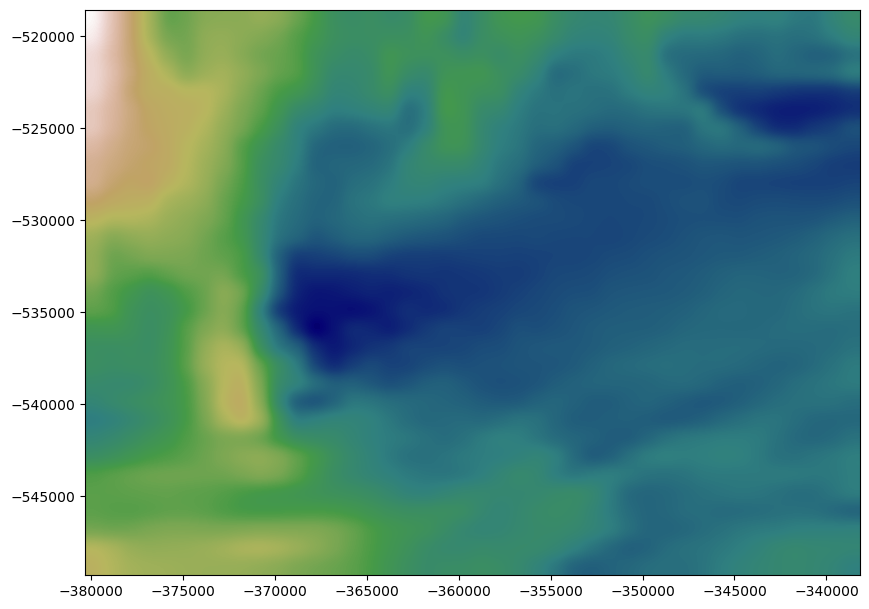

In [27]:
# test function working using one lake
# S09SF18varoutlines_hydropotential('Slessor_23', 7500, 0.5, CS2_dh, Bedmap2_ds)
# S09SF18varoutlines_hydropotential('Slessor_23', 7500, 0.5, ATL15_dh, Bedmap2_ds)
# S09SF18varoutlines_hydropotential('Slessor_23', 7500, 0.5, ATL15_dh, BedMachine_ds)
S09SF18varoutlines_hydropotential('UpperSubglacialLakeConway', 10000, 0.5, ATL15_dh, BedMachine_ds)

In [ ]:
# run func on all lakes from SF18 inventory
for idx in range(len(SiegfriedFricker2018_outlines)-1):
    lakename = SiegfriedFricker2018_outlines['name'][idx]
    S09SF18varoutlines_hydropotential(lakename, 7500, 0.5, ATL15_dh, Bedmap2_ds)
    # S09SF18varoutlines_hydropotential(lakename, 7500, 0.5, ATL15_dh, BedMachine_ds)
    S09SF18varoutlines_hydropotential(lakename, 7500, 0.5, CS2_dh, Bedmap2_ds)
    # S09SF18varoutlines_hydropotential(lakename, 7500, 0.5, CS2_dh, BedMachine_ds)

In [79]:
# 1x2 with Bedmap and Bedmachine side by side to compare; work in progress
def S09SF18varoutlines_hydropotential_compare(lakename_SF18, buffer, thres, altimetry_dataset, icebedgeom_dataset, icebedgeom_dataset2): 
    '''
    Create planview plot of hydropotential at ice-bedrock interface, calculated from ice surface and bedrock data (dataset). 
    Inputs: 
        lakename_SF18: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters away from SF18 lake outline used to create bounding box that is displayed around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
        altimetry.dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
        # icebedgeom.dataset: BedMachine Antarctica or Bedmap2
    Outputs: 
        Planview plot of of hydropotential at ice-bedrock interface with overlay of known lake boundary from published lake inventory. 
    '''
    # isolate individual lake using gpd buffer
    lake_gpd = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_SF18]
    lake_buffer = lake_gpd.buffer(buffer)
    # define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # subset ATL15 data set to region of interest
    mask_x = (altimetry_dataset.x >= x_min) & (altimetry_dataset.x <= x_max)
    mask_y = (altimetry_dataset.y >= y_min) & (altimetry_dataset.y <= y_max)
    ds_sub = altimetry_dataset.where(mask_x & mask_y, drop=True)
    icebedgeom_dataset_sub = icebedgeom_dataset.where(mask_x & mask_y, drop=True)
    icebedgeom_dataset_sub2 = icebedgeom_dataset2.where(mask_x & mask_y, drop=True)
    # plot figure
    fig, axs = plt.subplots(1,2, sharey=True, figsize=(10,10))
    # set colormap
    cmap = plt.get_cmap('CMRmap')
    # linearly normalize data to time axis for plotting purposes
    norm = plt.Normalize(ds_sub.time.values[0],ds_sub.time.values[-1])
    for ax in axs:
        # set axis to equal so x and y are lengths are plotted equally   
        ax.set_aspect('equal')
        # set axes limits
        ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
    # display hydropotential surface
    mappable = axs[0].imshow(icebedgeom_dataset_sub['hydropotential_kPa_static'], interpolation='gaussian', extent=[x_min, x_max, y_min, y_max], cmap='gist_earth')
    axs[1].imshow(icebedgeom_dataset_sub2['hydropotential_kPa_static'], interpolation='gaussian', extent=[x_min, x_max, y_min, y_max], cmap='gist_earth')
    # create empty list to store data
    dates = []
    # create contours iteratively at each time step 
    for idx in range(len(ds_sub.time)-1): 
        # calculate dhdt diff between orbital cycles of delta_h
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # calculate mid-cycle dates for plotting
        if altimetry_dataset.Title == 'CS2':
            newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif altimetry_dataset.Title == 'IS2':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        # create empty lists to store contour data
        contours_fill = []
        contours_drain = []
        # create contours of ice surface elevation height changes to delineate variable lake outlines       
        contour = measure.find_contours(dhdt.values, thres)
        if len(contour) > 0: 
            contours_fill += [contour]
        contour = measure.find_contours(dhdt.values, -thres)
        if len(contour) > 0: 
            contours_drain += [contour]
        # create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
        # plot variable outlines found in this time slice
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                for ax in axs: 
                    ax.plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (3, 1, 1, 1)), linewidth=1) 
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                for ax in axs: 
                    ax.plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (5, 1)), linewidth=1)
    # change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    for ax in axs:
        ax.xaxis.set_major_formatter(ticks_x)
        ax.yaxis.set_major_formatter(ticks_y)  
        # label axes
        ax.set_xlabel('polar stereographic x [km]', size=10)
        ax.set_ylabel('polar stereographic y [km]', size=10)
    # create colorbars
    # divider = make_axes_locatable(axes[0])
    # cax = divider.append_axes('right', size='4%', pad=0.2)
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes('right', size='4%', pad=0.2)
    fig.colorbar(mappable, cax=cax, label='Hydropotential (kPa)')#.set_label('BedMachine hydropotential (kPa)', size=15)
    mappable2 = plt.cm.ScalarMappable(cmap=cmap)
    mappable2.set_array(np.array([datetime2fracyear(date) for date in dates[0:-1]]))
    cax2 = divider.append_axes('top', size='2.5%', pad=0.5)
    fig.colorbar(mappable2, cax=cax2, orientation='horizontal', label='Year')#.set_label('Year', size=15)
    for ax in axs:
        # overlay published outlines for visual comparison 
        Smith2009_outlines.boundary.plot(ax=ax, color='k', linestyle=(0, (1, 5)), linewidth=1)
        SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, color='k', linestyle=(0, (1, 1)), linewidth=1)
    Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 5)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 1)), linewidth=2)
    uplift = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
    subsidence = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (5, 1)), linewidth=1)
    axs[0].legend([Smith2009,SiegfriedFricker2018,uplift, subsidence],['Smith and others, 2009 static outline', 'Siegfried & Fricker, 2018 static outline', ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], loc='upper left')
    # plot inset map to show location 
    axIns = axs[0].inset_axes([0.05, 0.001, 0.25, 0.25])
    axIns.patch.set_facecolor('lightskyblue')
    axIns.set_aspect('equal')
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
    Scripps_gl.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.5, zorder=2)
    axIns.axis('off')
    # save and close figure
    plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_lake-hydropotential/S09SF18varoutlines_hydropotential_compare/S09SF18varoutlines_hydropotential_compare-{}-{}-{}-{}.png'.format(lakename_SF18, altimetry_dataset.Title, icebedgeom_dataset.Title, icebedgeom_dataset2.Title), dpi=300, bbox_inches = "tight")
    plt.close()

In [ ]:
# test function working using one lake
# S09SF18varoutlines_hydropotential_compare('Slessor_23', 7500, 0.5, CS2_dh, Bedmap2_ds)
S09SF18varoutlines_hydropotential_compare('Slessor_23', 7500, 0.5, ATL15_dh, Bedmap2_ds, BedMachine_ds)
# S09SF18varoutlines_hydropotential_compare('Slessor_23', 7500, 0.5, ATL15_dh, BedMachine_ds)

In [ ]:
# run func on all lakes from SF18 inventory
for idx in range(len(SiegfriedFricker2018_outlines)-1):
    lakename = SiegfriedFricker2018_outlines['name'][idx]
    S09SF18varoutlines_hydropotential_compare(lakename, 7500, 0.5, ATL15_dh, Bedmap2_ds, BedMachine_ds)
    S09SF18varoutlines_hydropotential_compare(lakename, 7500, 0.5, CS2_dh, Bedmap2_ds, BedMachine_ds)

In [ ]:
# make into trellis plot of time series of ice surface height changes influencing hydropotential
def SF18lakes_hydropot(lakename_SF18, buffer): 
    '''
    Create planview plot of hydropotential at ice-bedrock interface, calculated from BedMachine Antarctica ice surface and bedrock data. 
    Inputs: 
        lakename_SF18: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters away from SF18 lake outline used to create bounding box that is displayed around lake of interest
    Outputs: 
        Planview plot of of hydropotential at ice-bedrock interface with overlay of known lake boundary from published lake inventory. 
    '''
    # isolate individual lake using gpd buffer
    #lake_gpd = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename_SF18]
    lake_gpd = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_SF18]
    lake_buffer = lake_gpd.buffer(buffer)
    # define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # subset ATL15 data set to region of interest
    mask_x = (ATL15_dh.x >= x_min) & (ATL15_dh.x <= x_max)
    mask_y = (ATL15_dh.y >= y_min) & (ATL15_dh.y <= y_max)
    ATL15_dh_sub = ATL15_dh.where(mask_x & mask_y, drop=True)
    #plot figure
    fig, ax = plt.subplots(3, 5, sharex=True, sharey=True, figsize=(15,7.5))
    for i, ax in enumerate(fig.axes): 
        m = ax.imshow(ATL15_dh_sub['hydropotential_kPa_BedMachine'][i], extent=[x_min, x_max, y_min, y_max], cmap='gist_earth')
        ax.set_aspect('equal')
        ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
        # Change polar stereographic m to km
        km_scale = 1e3
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax.xaxis.set_major_formatter(ticks_x)
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax.yaxis.set_major_formatter(ticks_y)  
        # adjust ticks
        ax.set_xticks(np.arange(np.round(x_min, decimals = -3),np.round(x_max, decimals = -3),10000))
        ax.set_yticks(np.arange(np.round(y_min, decimals = -3),np.round(y_max, decimals = -3),10000))
    # # label axes
    # ax.set_xlabel('polar stereographic x [km]', size=15)
    # ax.set_ylabel('polar stereographic y [km]', size=15)
    # # create colorbar and append to axes
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='5%', pad=0.2)
    # fig.colorbar(m, cax=cax).set_label('Hydropotential (MPa)', size=15)
    # overlay published outlines for visual comparison 
        Smith2009_outlines.boundary.plot(ax=ax, color='k', linestyle=(0, (1, 5)), linewidth=1)
        SiegfriedFricker2018_outlines.boundary.plot(ax=ax, color='k', linestyle=(0, (1, 1)), linewidth=1)
    Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 5)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 1)), linewidth=2)
    ax.legend([Smith2009,SiegfriedFricker2018],
        ['Smith and others, 2009 outline','Siegfried & Fricker, 2018 outline'], 
        loc='best')
    # plot inset map to show location 
    axIns = ax.inset_axes([0.05, 0.001, 0.25, 0.25])
    axIns.patch.set_facecolor('lightskyblue')
    axIns.set_aspect('equal')
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
        linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
    Scripps_gl.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.5, zorder=2)
    axIns.axis('off')
    # save and close figure
    plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/lake-hydropotential_output/SF18lakes_hydropot/SF18lakes_hydropot-{}.png'.format(lakename_SF18), dpi=300, bbox_inches = "tight")
    plt.close()

In [56]:
# test function working using one lake
SF18lakes_hydropot('Whillans_7', 10000)

In [57]:
# run func on all lakes from SF18 inventory
for idx in range(len(SiegfriedFricker2018_outlines)-1):
    lakename=SiegfriedFricker2018_outlines['name'][idx]
    SF18lakes_hydropot(lakename, 7500)

In [84]:
def S09SF18varoutlines_bedelev(lakename_SF18, buffer, thres, altimetry_dataset, icebedgeom_dataset): 
    '''
    Create planview plot of bed elevation along with various lake outlines (static and variable). 
    Inputs: 
        lakename_SF18: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters away from SF18 lake outline used to create bounding box that is displayed around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
        altimetry.dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
        icebedgeom.dataset: BedMachine Antarctica or Bedmap2
    Outputs: 
        Planview plot of of bed elevation with overlay of known lake boundary from published lake inventory and variable lake outlines. 
    '''
    # isolate individual lake using gpd buffer
    lake_gpd = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_SF18]
    lake_buffer = lake_gpd.buffer(buffer)
    # define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # subset ATL15 data set to region of interest
    mask_x = (altimetry_dataset.x >= x_min) & (altimetry_dataset.x <= x_max)
    mask_y = (altimetry_dataset.y >= y_min) & (altimetry_dataset.y <= y_max)
    ds_sub = altimetry_dataset.where(mask_x & mask_y, drop=True)
    icebedgeom_dataset_sub = icebedgeom_dataset.where(mask_x & mask_y, drop=True)
    # plot figure
    fig, ax = plt.subplots(figsize=(10,10))
    # set colormap
    cmap = plt.get_cmap('CMRmap')
    # linearly normalize data to time axis for plotting purposes
    norm = plt.Normalize(ds_sub.time.values[0],ds_sub.time.values[-1])
    # set axis to equal so x and y are lengths are plotted equally   
    ax.set_aspect('equal')
    # set axes limits
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
    # display hydropotential surface
    mappable = ax.imshow(icebedgeom_dataset_sub['bed'], interpolation='gaussian', extent=[x_min, x_max, y_min, y_max], cmap='gist_earth')
    # create empty list to store data
    dates = []
    # create contours iteratively at each time step 
    for idx in range(len(ds_sub.time)-1): 
        # calculate dhdt diff between orbital cycles of delta_h
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # calculate mid-cycle dates for plotting
        if altimetry_dataset.Title == 'CS2':
            newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif altimetry_dataset.Title == 'IS2':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        # create empty lists to store contour data
        contours_fill = []
        contours_drain = []
        # create contours of ice surface elevation height changes to delineate variable lake outlines       
        contour = measure.find_contours(dhdt.values, thres)
        if len(contour) > 0: 
            contours_fill += [contour]
        contour = measure.find_contours(dhdt.values, -thres)
        if len(contour) > 0: 
            contours_drain += [contour]
        # create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
        # plot variable outlines found in this time slice
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                ax.plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, 
                color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (3, 1, 1, 1)), linewidth=1) 
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                ax.plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, 
                color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (5, 1)), linewidth=1)
    # change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)  
    # label axes
    ax.set_xlabel('polar stereographic x [km]', size=10)
    ax.set_ylabel('polar stereographic y [km]', size=10)
    # create colorbars
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.2)
    if icebedgeom_dataset.Title == 'Bedmap2': 
        fig.colorbar(mappable, cax=cax, label='Bedmap2 bed elevation (m)')#.set_label('Bedmap2 hydropotential (kPa)', size=15)
    elif icebedgeom_dataset.Title == 'BedMachine Antarctica':
        fig.colorbar(mappable, cax=cax, label='BedMachine bed elevation (m)')#.set_label('BedMachine hydropotential (kPa)', size=15)
    mappable2 = plt.cm.ScalarMappable(cmap=cmap)
    mappable2.set_array(np.array([datetime2fracyear(date) for date in dates[0:-1]]))
    cax2 = divider.append_axes('top', size='2.5%', pad=0.5)
    fig.colorbar(mappable2, cax=cax2, orientation='horizontal', label='Year')#.set_label('Year', size=15)
    # overlay published outlines for visual comparison 
    Smith2009_outlines.boundary.plot(ax=ax, color='k', linestyle=(0, (1, 5)), linewidth=1)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, color='k', linestyle=(0, (1, 1)), linewidth=1)
    Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 5)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 1)), linewidth=2)
    uplift = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
    subsidence = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (5, 1)), linewidth=1)
    ax.legend([Smith2009,SiegfriedFricker2018,uplift, subsidence],['Smith and others, 2009 static outline', 'Siegfried & Fricker, 2018 static outline', ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], loc='upper left')
    # plot inset map to show location 
    axIns = ax.inset_axes([0.05, 0.001, 0.25, 0.25])
    axIns.patch.set_facecolor('lightskyblue')
    axIns.set_aspect('equal')
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
    Scripps_gl.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.5, zorder=2)
    axIns.axis('off')
    # save and close figure
    plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_lake-hydropotential/S09SF18varoutlines_bedelev/S09SF18varoutlines_bedelev-{}-{}-{}.png'.format(lakename_SF18, altimetry_dataset.Title, icebedgeom_dataset.Title), dpi=300, bbox_inches = "tight")
    plt.close()

In [89]:
# test function working using one lake
S09SF18varoutlines_bedelev('Rec1', 7500, 0.5, ATL15_dh, BedMachine_ds)

In [105]:
# run func on all lakes from SF18 inventory
for idx in range(len(SiegfriedFricker2018_outlines)-1):
    lakename=SiegfriedFricker2018_outlines['name'][idx]
    S09SF18varoutlines_bedelev(lakename, 7500, 0.5, ATL15_dh, Bedmap2_ds)
    S09SF18varoutlines_bedelev(lakename, 7500, 0.5, ATL15_dh, BedMachine_ds)
    S09SF18varoutlines_bedelev(lakename, 7500, 0.5, CS2_dh, Bedmap2_ds)
    S09SF18varoutlines_bedelev(lakename, 7500, 0.5, CS2_dh, BedMachine_ds)

In [87]:
# surf
def S09SF18varoutlines_surfelev(lakename_SF18, buffer, thres, altimetry_dataset, icebedgeom_dataset): 
    '''
    Create planview plot of bed elevation along with various lake outlines (static and variable). 
    Inputs: 
        lakename_SF18: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters away from SF18 lake outline used to create bounding box that is displayed around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
        altimetry.dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
        icebedgeom.dataset: BedMachine Antarctica or Bedmap2
    Outputs: 
        Planview plot of of bed elevation with overlay of known lake boundary from published lake inventory and variable lake outlines. 
    '''
    # isolate individual lake using gpd buffer
    lake_gpd = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_SF18]
    lake_buffer = lake_gpd.buffer(buffer)
    # define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # subset ATL15 data set to region of interest
    mask_x = (altimetry_dataset.x >= x_min) & (altimetry_dataset.x <= x_max)
    mask_y = (altimetry_dataset.y >= y_min) & (altimetry_dataset.y <= y_max)
    ds_sub = altimetry_dataset.where(mask_x & mask_y, drop=True)
    icebedgeom_dataset_sub = icebedgeom_dataset.where(mask_x & mask_y, drop=True)
    # plot figure
    fig, ax = plt.subplots(figsize=(10,10))
    # set colormap
    cmap = plt.get_cmap('CMRmap')
    # linearly normalize data to time axis for plotting purposes
    norm = plt.Normalize(ds_sub.time.values[0],ds_sub.time.values[-1])
    # set axis to equal so x and y are lengths are plotted equally   
    ax.set_aspect('equal')
    # set axes limits
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
    # display hydropotential surface
    mappable = ax.imshow(icebedgeom_dataset_sub['surface'], interpolation='gaussian', extent=[x_min, x_max, y_min, y_max], cmap='gist_earth')
    # create empty list to store data
    dates = []
    # create contours iteratively at each time step 
    for idx in range(len(ds_sub.time)-1): 
        # calculate dhdt diff between orbital cycles of delta_h
        dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
        # calculate mid-cycle dates for plotting
        if altimetry_dataset.Title == 'CS2':
            newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        elif altimetry_dataset.Title == 'IS2':    
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays/2
            dates += [midcycdate]
        # create empty lists to store contour data
        contours_fill = []
        contours_drain = []
        # create contours of ice surface elevation height changes to delineate variable lake outlines       
        contour = measure.find_contours(dhdt.values, thres)
        if len(contour) > 0: 
            contours_fill += [contour]
        contour = measure.find_contours(dhdt.values, -thres)
        if len(contour) > 0: 
            contours_drain += [contour]
        # create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt.shape[1]
        y_conv = (y_max-y_min)/dhdt.shape[0]
        # plot variable outlines found in this time slice
        for i in range(len(contours_fill)): 
            for j in range(len(contours_fill[i])):
                ax.plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, 
                color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (3, 1, 1, 1)), linewidth=1) 
        for i in range(len(contours_drain)): 
            for j in range(len(contours_drain[i])):
                ax.plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, 
                color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (5, 1)), linewidth=1)
    # change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)  
    # label axes
    ax.set_xlabel('polar stereographic x [km]', size=10)
    ax.set_ylabel('polar stereographic y [km]', size=10)
    # create colorbars
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.2)
    if icebedgeom_dataset.Title == 'Bedmap2': 
        fig.colorbar(mappable, cax=cax, label='Bedmap2 ice surface elevation (m)')#.set_label('Bedmap2 hydropotential (kPa)', size=15)
    elif icebedgeom_dataset.Title == 'BedMachine Antarctica':
        fig.colorbar(mappable, cax=cax, label='BedMachine ice surface elevation (m)')#.set_label('BedMachine hydropotential (kPa)', size=15)
    mappable2 = plt.cm.ScalarMappable(cmap=cmap)
    mappable2.set_array(np.array([datetime2fracyear(date) for date in dates[0:-1]]))
    cax2 = divider.append_axes('top', size='2.5%', pad=0.5)
    fig.colorbar(mappable2, cax=cax2, orientation='horizontal', label='Year')#.set_label('Year', size=15)
    # overlay published outlines for visual comparison 
    Smith2009_outlines.boundary.plot(ax=ax, color='k', linestyle=(0, (1, 5)), linewidth=1)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, color='k', linestyle=(0, (1, 1)), linewidth=1)
    Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 5)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 1)), linewidth=2)
    uplift = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
    subsidence = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (5, 1)), linewidth=1)
    ax.legend([Smith2009,SiegfriedFricker2018,uplift, subsidence],['Smith and others, 2009 static outline', 'Siegfried & Fricker, 2018 static outline', ('+'+str(thres)+' m uplift (filling) variable outline'), '–'+str(thres)+' m subsidence (draining) variable outline'], loc='upper left')
    # plot inset map to show location 
    axIns = ax.inset_axes([0.05, 0.001, 0.25, 0.25])
    axIns.patch.set_facecolor('lightskyblue')
    axIns.set_aspect('equal')
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
    Scripps_gl.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.5, zorder=2)
    axIns.axis('off')
    # save and close figure
    plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output_lake-hydropotential/S09SF18varoutlines_surfelev/S09SF18varoutlines_surfelev-{}-{}-{}.png'.format(lakename_SF18, altimetry_dataset.Title, icebedgeom_dataset.Title), dpi=300, bbox_inches = "tight")
    plt.close()

In [90]:
# test function working using one lake
S09SF18varoutlines_surfelev('Rec1', 7500, 0.5, ATL15_dh, BedMachine_ds)

In [106]:
# run func on all lakes from SF18 inventory
for idx in range(len(SiegfriedFricker2018_outlines)-1):
    lakename=SiegfriedFricker2018_outlines['name'][idx]
    S09SF18varoutlines_surfelev(lakename, 7500, 0.5, ATL15_dh, Bedmap2_ds)
    S09SF18varoutlines_surfelev(lakename, 7500, 0.5, ATL15_dh, BedMachine_ds)
    S09SF18varoutlines_surfelev(lakename, 7500, 0.5, CS2_dh, Bedmap2_ds)
    S09SF18varoutlines_surfelev(lakename, 7500, 0.5, CS2_dh, BedMachine_ds)

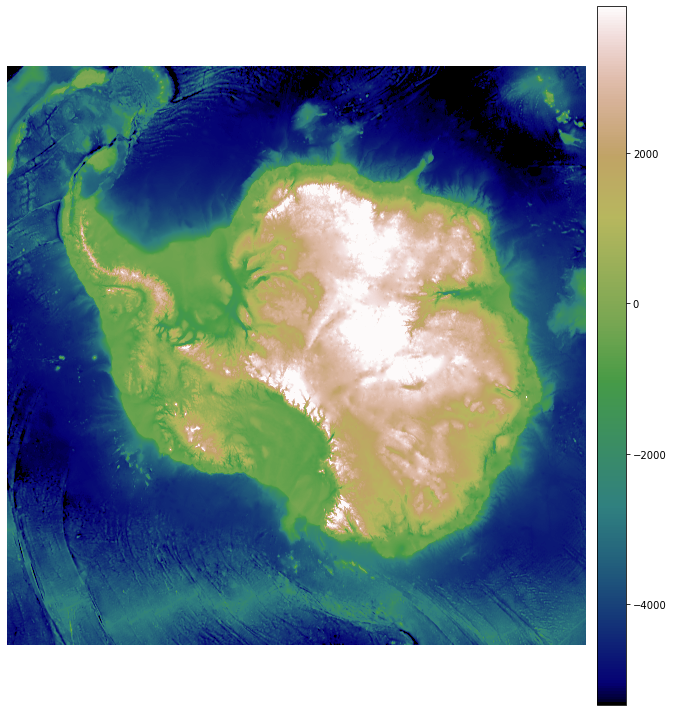

In [41]:
hydropot_rd = rd.rdarray(hydropot, no_data=-9999)
rd.rdShow(hydropot_rd, ignore_colours=[0], axes=False, cmap='gist_earth', figsize=(10,10));

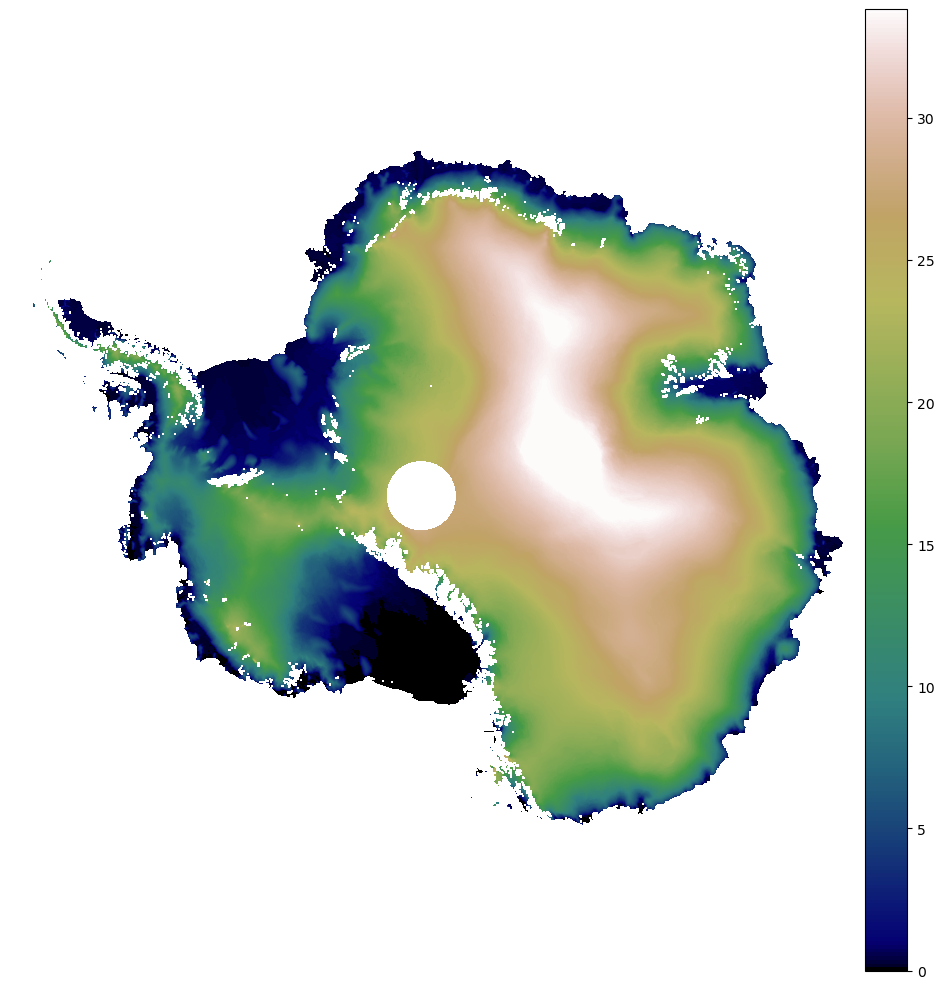

In [59]:
# using corrected hydropotential
hydropot_rd = rd.rdarray(ATL15_dh['hydropotential_kPa_BedMachine'][0], no_data=-9999)
rd.rdShow(hydropot_rd, ignore_colours=[0], axes=False, cmap='gist_earth', figsize=(10,10));

In [60]:
# fill depressions in hydropotential DEM
# use rd FillDepressions method to identify and fill the depressions in the DEM
hydropot_rd_filled = rd.FillDepressions(hydropot_rd, in_place=False)
# alternate depression filling method using epsilon parameter
# epsilon parameter = true applies a small gradient toward the lowest egress 
# to avoid creating flat regions of ambigious flow
# hydropot_rd_epsfilled = rd.FillDepressions(hydropot_rd, epsilon=True, in_place=False)
# use Barnes (2014) method to epsilon fill
hydropot_rd_flateps = rd.ResolveFlats(hydropot_rd_filled, in_place=False)
# breach depressions (aka stream etching)
# hydropot_rd_breached = rd.BreachDepressions(hydropot_rd, in_place=False)

# # plot comparison figures of original hydropotential DEM and filled DEMs
# rd.rdShow(hydropot_rd, ignore_colours=[0], 
#     axes=False, cmap='jet', figsize=(8,6));
# rd.rdShow(hydropot_rd_filled, ignore_colours=[0], 
#     axes=False, cmap='jet', 
#     vmin=hydropot_rd_fig['vmin'], vmax=hydropot_rd_fig['vmax'], 
#     figsize=(8,6))
# rd.rdShow(hydropot_rd_epsfilled, ignore_colours=[0], 
#     axes=False, cmap='jet', 
#     vmin=hydropot_rd_fig['vmin'], vmax=hydropot_rd_fig['vmax'], 
#     figsize=(8,6))
# rd.rdShow(hydropot_rd_flateps, ignore_colours=[0], 
#     axes=False, cmap='jet', 
#     vmin=hydropot_rd_fig['vmin'], vmax=hydropot_rd_fig['vmax'], 
#     figsize=(8,6))
# rd.rdShow(hydropot_rd_breached, ignore_colours=[0], 
#     axes=False, cmap='jet', 
#     vmin=hydropot_rd_fig['vmin'], 
#     vmax=hydropot_rd_fig['vmax'], 
#     figsize=(8,6));

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Priority-Flood (Zhou2016 version)
C Zhou, G., Sun, Z., Fu, S., 2016. An efficient variant of the Priority-Flood algorithm for filling depressions in raster digital elevation models. Computers & Geosciences 90, Part A, 87 – 96. doi:http://dx.doi.org/10.1016/j.cageo.2016.02.021

t Zhou2016 wall-time = 1.50461 s

A Barnes (2014) Flat Resolution Flat Mask Generation
C Barnes, R., Lehman, C., Mulla, D., 2014a. An efficient assignment of drainage direction over flat surfaces in raster digital elevation models. Computers & Geosciences 62, 128–135. doi:10.1016/j.cageo.2013.01.009

t Succeeded in = 0.224435 s
p Setting up labels matrix...
p Setting up flat resolution mask...
p Searching for flats...
t Succeeded in = 0.3423 s==================== ] (99% - 0.0s - 1 threads)
m Cells with no flow direction = 16817730
m Low edge cells               = 284785
m High edge cells              = 241696
p Labeling flats...
m Unique flats = 25305
p Removing flats without outlets from the queue...
W Not al

In [61]:
# calculate the flow accumulation on convergent-elevation adjusted, epsilon-filled hydropotential map
accum_Dinf_flateps = rd.FlowAccumulation(hydropot_rd_flateps, method="Dinf")

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Tarboton (1997) Flow Accumulation (aka D-Infinity, D∞)
C Tarboton, D.G., 1997. A new method for the determination of flow directions and upslope areas in grid digital elevation models. Water resources research 33, 309–319.

[================================================= ] (99% - 0.1s - 1 threads)
A Generic Flow Accumulation Algorithm
p Creating dependencies array...

d Source cells found = 2446361
p Calculating flow accumulation...
t Wall-time       = 2.98627 s================ ] (99% - 0.0s - 1 threads)


In [62]:
alpha = NormalizeData(accum_Dinf_flateps)

In [63]:
type(np.array(alpha))

numpy.ndarray

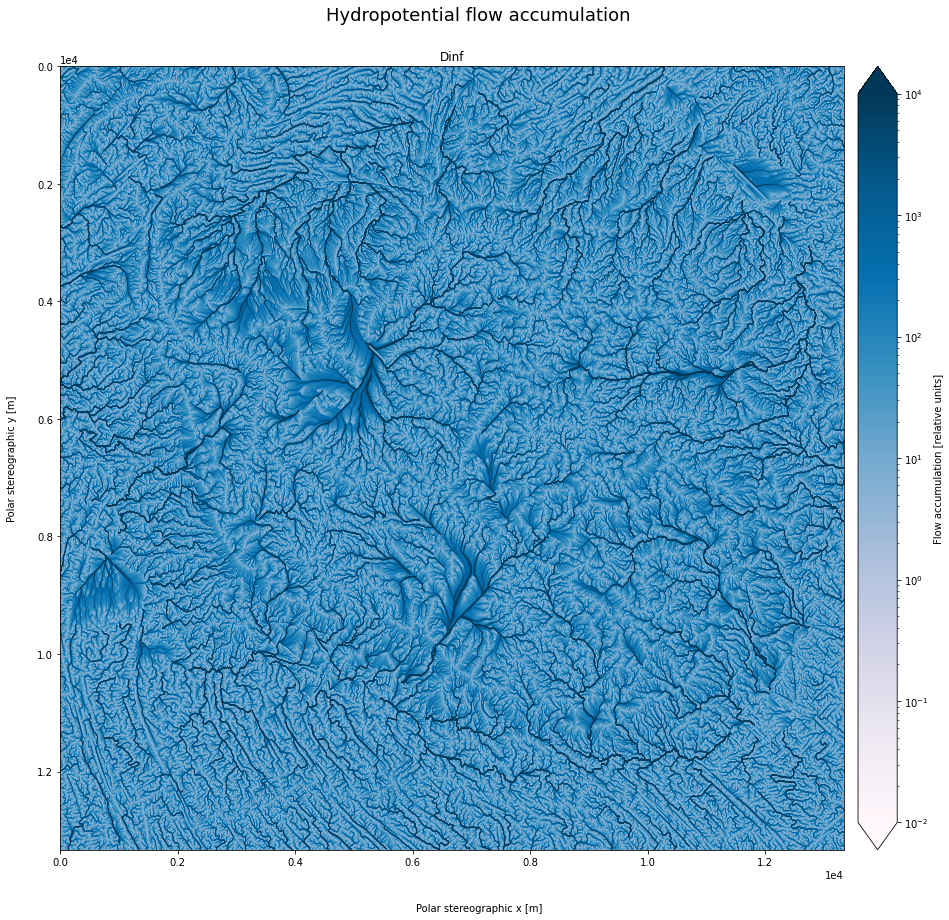

In [48]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(15,15))
fig.add_subplot(111, frameon=False)
plt.xlabel('Polar stereographic x [m]',labelpad=20)
plt.ylabel('Polar stereographic y [m]',labelpad=20)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

sc = ax.imshow(accum_Dinf_flateps, cmap='PuBu',
           #extent=[xmin,xmax,ymin,ymax],
        #    alpha = np.array(NormalizeData(accum_Dinf_flateps)))
           norm=LogNorm(vmin=0.01, vmax=10000))
ax.set_title('Dinf')

# apply common adjustments to all plots
# for ax in axs.flat:
ax.set_aspect('equal')
# ax.set_ylim(ymin,ymax)
# ax.set_xlim(xmin,xmax)
ax.ticklabel_format(axis='both',scilimits=(0,0))
# SiegfriedFricker2018_newoutlines.boundary.plot(ax=ax, color='k', linewidth=1)
# Smith2009_outlines.boundary.plot(ax=ax, color='k', linewidth=1)
# Scripps_gl.boundary.plot(ax=ax, edgecolor='white', linewidth=1)

plt.title('Hydropotential flow accumulation', pad=30, fontsize=18)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
plt.colorbar(sc, cax=cax,
    label='Flow accumulation [relative units]', 
    extend='both',extendfrac=0.0375,
    drawedges=False,fraction=0.05)
plt.show()

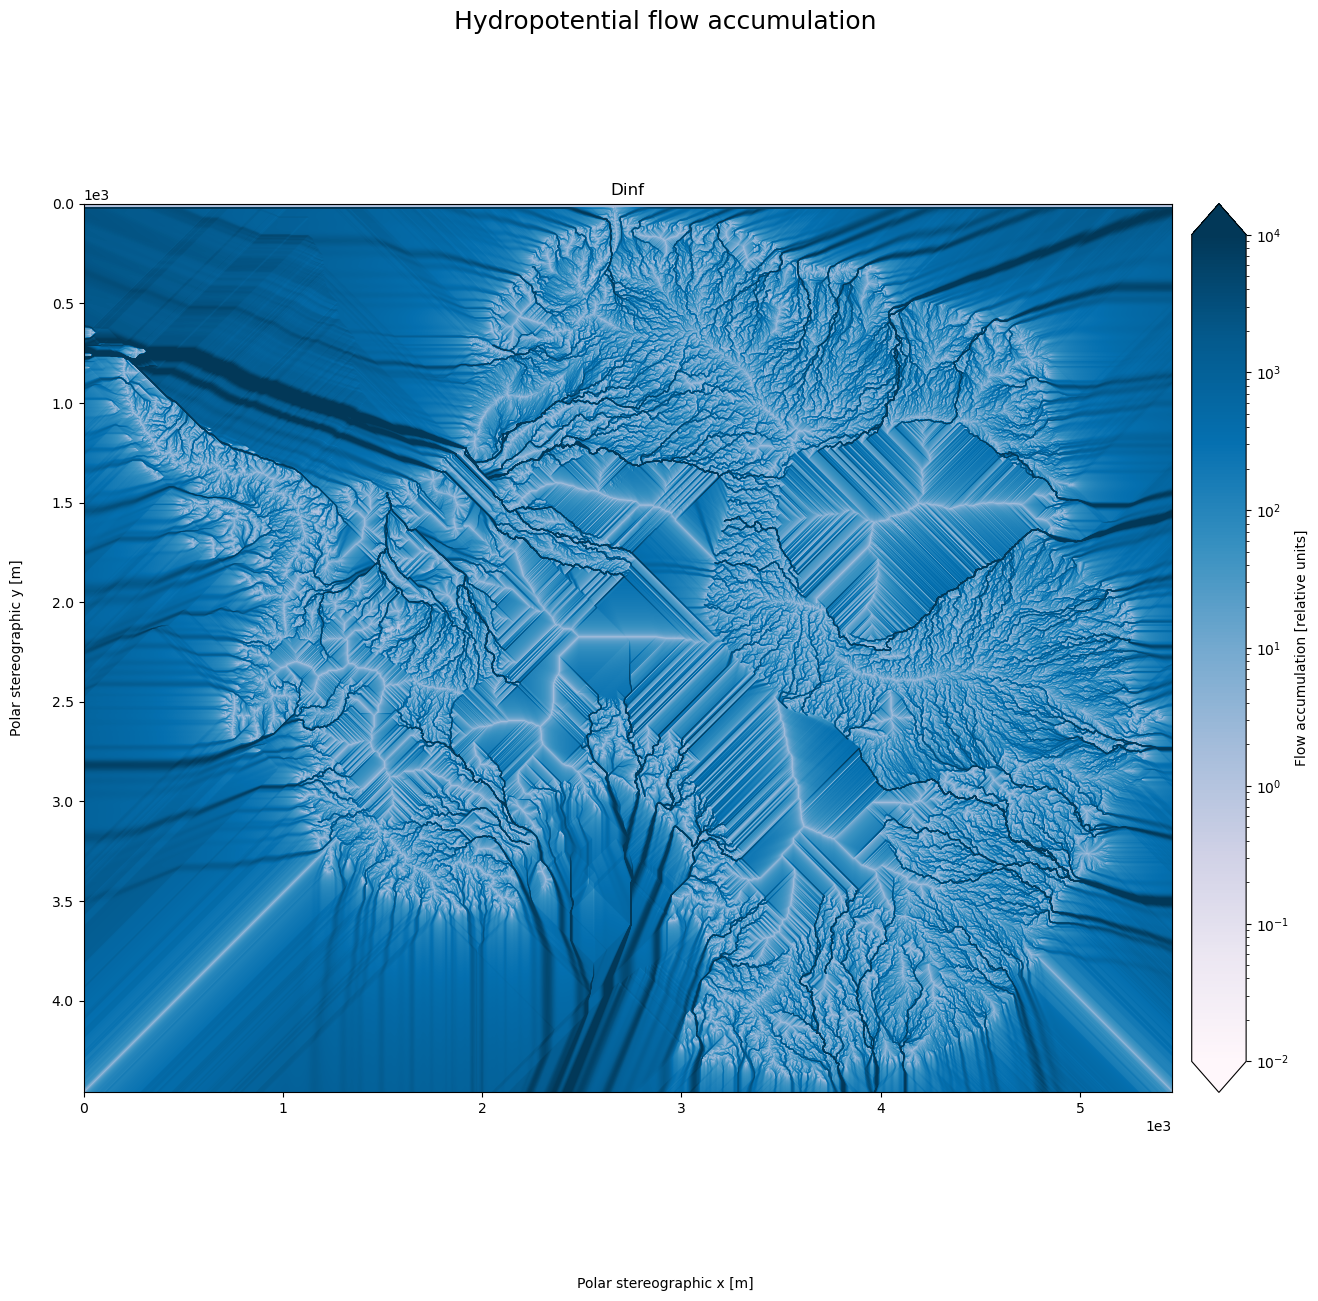

In [64]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(15,15))
fig.add_subplot(111, frameon=False)
plt.xlabel('Polar stereographic x [m]',labelpad=20)
plt.ylabel('Polar stereographic y [m]',labelpad=20)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

sc = ax.imshow(accum_Dinf_flateps, cmap='PuBu',
           #extent=[xmin,xmax,ymin,ymax],
        #    alpha = np.array(NormalizeData(accum_Dinf_flateps)))
           norm=LogNorm(vmin=0.01, vmax=10000))
ax.set_title('Dinf')

# apply common adjustments to all plots
# for ax in axs.flat:
ax.set_aspect('equal')
# ax.set_ylim(ymin,ymax)
# ax.set_xlim(xmin,xmax)
ax.ticklabel_format(axis='both',scilimits=(0,0))
# SiegfriedFricker2018_newoutlines.boundary.plot(ax=ax, color='k', linewidth=1)
# Smith2009_outlines.boundary.plot(ax=ax, color='k', linewidth=1)
# Scripps_gl.boundary.plot(ax=ax, edgecolor='white', linewidth=1)

plt.title('Hydropotential flow accumulation', pad=30, fontsize=18)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
plt.colorbar(sc, cax=cax,
    label='Flow accumulation [relative units]', 
    extend='both',extendfrac=0.0375,
    drawedges=False,fraction=0.05)
plt.show()

In [ ]:
def SF18lakes_hydropot(lakename_SF18, buffer): 
    '''
    Create planview plot of hydropotential at ice-bedrock interface, calculated from BedMachine Antarctica ice surface and bedrock data. 
    Inputs: 
        lakename_SF18: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters away from SF18 lake outline used to create bounding box that is displayed around lake of interest
    Outputs: 
        Planview plot of of hydropotential at ice-bedrock interface with overlay of known lake boundary from published lake inventory. 
    '''
    # isolate individual lake using gpd buffer
    #lake_gpd = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename_SF18]
    lake_gpd = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_SF18]
    lake_buffer = lake_gpd.buffer(buffer)